In [ ]:
import os
import importlib

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.inspection import permutation_importance
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score


from customer_segmentation.utils import functions

importlib.reload(functions)

# Set pandas to display all columns
pd.set_option("display.max_columns", None)

In [2]:
# import data
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, os.path.pardir, "data")
file_name = "cohort_data.csv"
file_path = os.path.join(data_dir, file_name)

cohort = pd.read_csv(file_path)

### **Preprocessing**

In [3]:
# convert data & seperate binary and numeric values

cohort["user_id"] = cohort["user_id"].astype(str)
# get binary and numeric values
binary_cols = functions.get_binary_columns(cohort)
numeric_cols = cohort.select_dtypes(include=[np.number]).columns.to_list()

**Select features for scaling & PCA**

In [4]:
feature_groups = {
    # Split discounts
    "flight_discount_score": [
        "avg_flight_discount",
        "flight_discount_rate",
        "discount_per_km",
    ],
    "hotel_discount_score": [
        "avg_hotel_discount",
        "hotel_discount_rate",
    ],
    # User demographics
    "user_score": ["age", "is_married", "has_children"],
    # Engagement
    "engagement_score": [
        "days_last_trip",
        "sessions_per_month",
        "avg_session_duration_seconds",
        "page_click_per_session",
    ],
    # Travel features split
    "flight_travel_score": [
        "avg_flight_travel_days",
        "avg_seats",
        "avg_checked_bags",
        "avg_distance_km",
        "flight_booked",
        "flight_booking_value",
    ],
    "hotel_travel_score": [
        "avg_rooms",
        "avg_hotel_nights",
        "hotel_booked",
        "hotel_booking_value",
    ],
    # Cancellations
    "cancellation_score": ["cancellation_rate"],
}

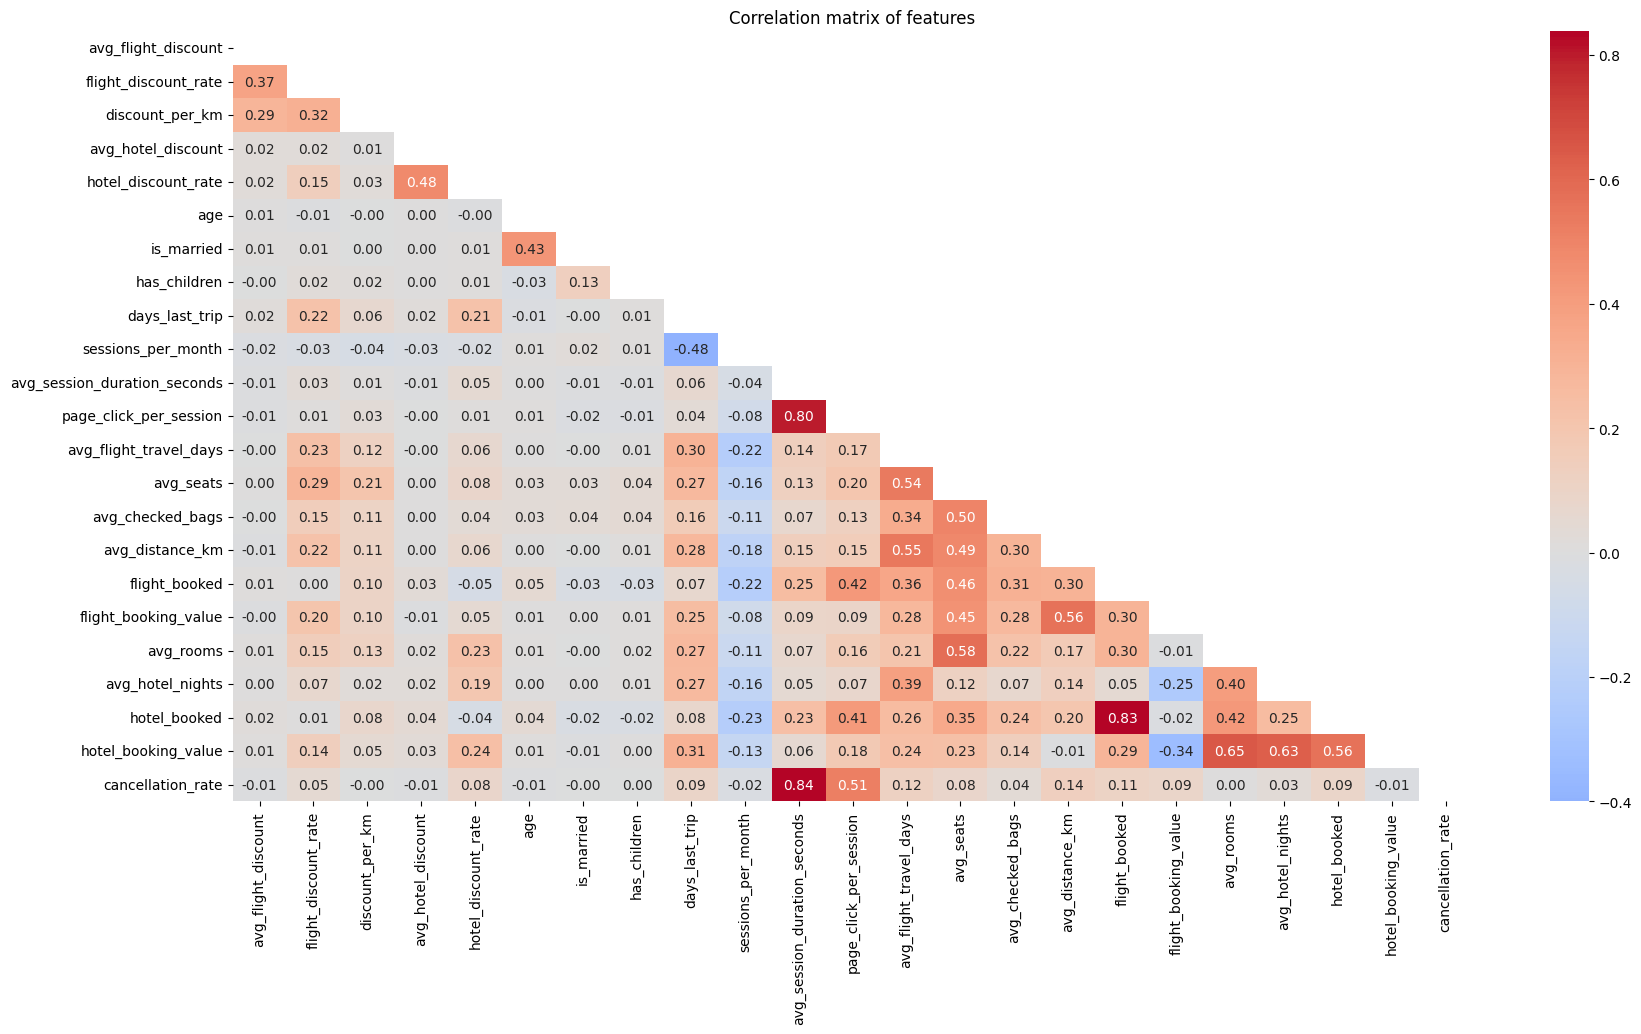

In [5]:
metrics = [m for _, metric in feature_groups.items() for m in metric]

matrix = np.triu(cohort[metrics].corr())
plt.figure(figsize=(20, 10))
plt.title("Correlation matrix of features", fontsize=12)
sns.heatmap(
    cohort[metrics].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-0.4,
    center=0,
    mask=matrix,
)
plt.show()

**Apply PCA per thematic groups**

In [6]:
for score_name, features in feature_groups.items():
    cohort = functions.PCA_pipeline(df=cohort, features=features, score_name=score_name)

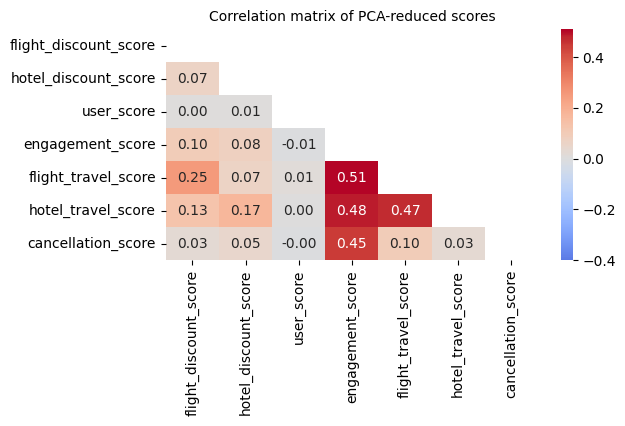

In [7]:
scores = [k for k in feature_groups.keys()]

matrix = np.triu(cohort[scores].corr())
plt.figure(figsize=(6, 3))
plt.title("Correlation matrix of PCA-reduced scores", fontsize=10)
sns.heatmap(
    cohort[scores].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-0.4,
    center=0,
    mask=matrix,
)
plt.show()

### **Clustering**

**Extract scores for clustering**

In [8]:
X = cohort[scores]

**Apply elbow-method to find k number of cluster**

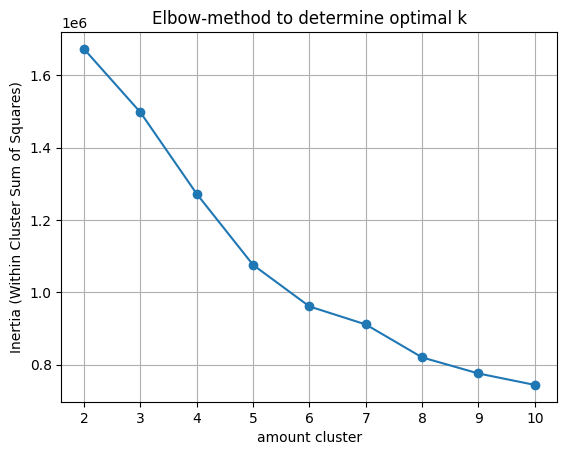

In [9]:
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=3, n_init="auto")
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, "o-")
plt.xlabel("amount cluster")
plt.ylabel("Inertia (Within Cluster Sum of Squares)")
plt.title("Elbow-method to determine optimal k")
plt.grid(True)
plt.show()

**Apply kmeans clustering**

In [10]:
kmeans = KMeans(n_clusters=6, random_state=3, n_init="auto")
cohort["kmeans_cluster"] = kmeans.fit_predict(X)

In [11]:
# mean values per cluster
cluster_profiles = cohort.groupby("kmeans_cluster")[scores].mean()

cluster_profiles.T.style.background_gradient(cmap="YlGnBu")

kmeans_cluster,0,1,2,3,4,5
flight_discount_score,1.838461,-0.735460,-0.614023,0.233877,-0.711405,-0.095413
hotel_discount_score,-0.381911,-0.618896,-1.046617,0.399429,0.429335,1.243679
user_score,0.013404,-0.009866,-0.016303,-0.028558,0.014779,0.007807
engagement_score,-0.080879,-1.955907,0.455116,4.963259,-0.484100,0.314739
flight_travel_score,0.848977,-3.549523,1.036374,1.497008,-3.582095,0.926805
hotel_travel_score,0.020067,-3.477184,0.565981,0.612451,1.095806,0.628675
cancellation_score,-0.130355,-0.130355,-0.130205,7.155010,-0.130355,-0.130227


**GGM clustering**

In [12]:
gmm = GaussianMixture(n_components=6, random_state=3)
cohort["gmm_cluster"] = gmm.fit_predict(X)

In [13]:
# mean values per cluster
cluster_profiles = cohort.groupby("gmm_cluster")[scores].mean()

cluster_profiles.T.style.background_gradient(cmap="YlGnBu")

gmm_cluster,0,1,2,3,4,5
flight_discount_score,1.032707,-0.731590,0.124657,0.233377,-0.710538,0.141966
hotel_discount_score,0.151020,-0.618022,-1.234666,0.398741,0.428807,1.029951
user_score,0.067060,-0.009601,-0.006703,-0.029064,0.013939,-0.001419
engagement_score,-0.231289,-1.956520,0.286105,4.960361,-0.482721,0.306050
flight_travel_score,1.687223,-3.589724,0.900772,1.497681,-3.589724,0.888687
hotel_travel_score,-2.336377,-3.477184,0.587683,0.614315,1.095905,0.687010
cancellation_score,-0.130355,-0.130355,-0.130355,7.150045,-0.130355,-0.130355


### **Compare cluster models**

In [14]:
# Adjusted Rand Index (ARI) measures the similarity of two cluster assignments

ari = adjusted_rand_score(cohort["kmeans_cluster"], cohort["gmm_cluster"])
print(f"Adjusted Rand Index: {ari:.2f}")

Adjusted Rand Index: 0.59


In [15]:
# validate KMeans
labels_kmeans = cohort["kmeans_cluster"]
db_kmeans = davies_bouldin_score(X, labels_kmeans)
ch_kmeans = calinski_harabasz_score(X, labels_kmeans)

print("KMeans - Davies-Bouldin:", round(db_kmeans, 2))
print("KMeans - Calinski-Harabasz:", round(ch_kmeans, 2))

# validate Gaussian Mixture Model
labels_gmm = cohort["gmm_cluster"]
db_gmm = davies_bouldin_score(X, labels_gmm)
ch_gmm = calinski_harabasz_score(X, labels_gmm)

print("GMM - Davies-Bouldin:", round(db_gmm, 2))
print("GMM - Calinski-Harabasz:", round(ch_gmm, 2))

KMeans - Davies-Bouldin: 1.31
KMeans - Calinski-Harabasz: 55781.57
GMM - Davies-Bouldin: 1.35
GMM - Calinski-Harabasz: 52637.79


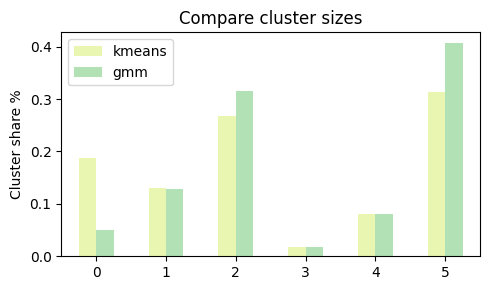

In [16]:
cluster_sizes = pd.DataFrame(
    {
        "kmeans": cohort["kmeans_cluster"].value_counts(normalize=True),
        "gmm": cohort["gmm_cluster"].value_counts(normalize=True),
    }
)
cluster_sizes.plot(kind="bar", color=sns.color_palette("YlGnBu"), figsize=(5, 3))
plt.title("Compare cluster sizes")
plt.xticks(rotation=0)
plt.ylabel("Cluster share %")
plt.tight_layout()
plt.show()

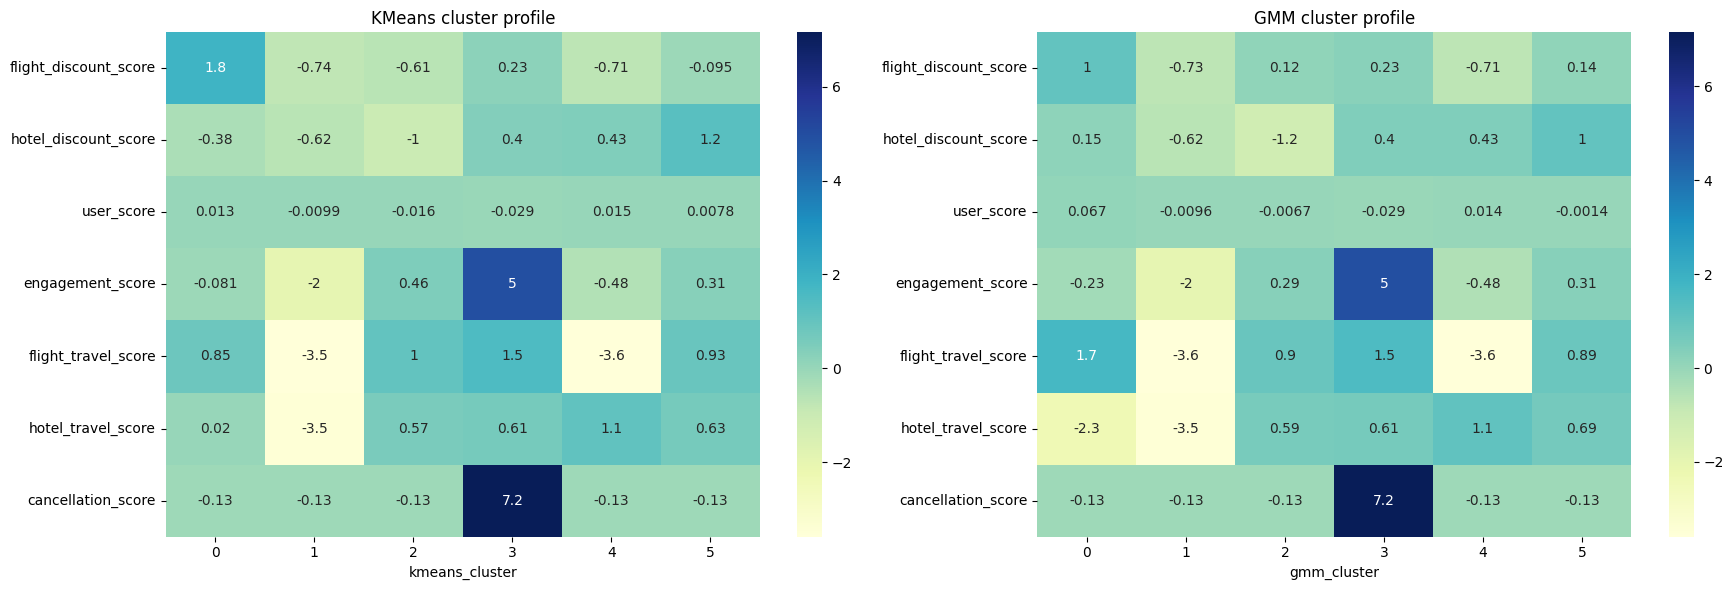

In [17]:
profiles_kmeans = cohort.groupby("kmeans_cluster")[scores].mean()
profiles_gmm = cohort.groupby("gmm_cluster")[scores].mean()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.heatmap(profiles_kmeans.T, ax=axes[0], cmap="YlGnBu", annot=True)
axes[0].set_title("KMeans cluster profile")

sns.heatmap(profiles_gmm.T, ax=axes[1], cmap="YlGnBu", annot=True)
axes[1].set_title("GMM cluster profile")

plt.tight_layout()
plt.show()

### **Conclusion**  
Kmeans performances slightly better than GMM regarding:  
davies_bouldin_score (lower value than GMM)  
calinski_harabasz_score (higher value than GMM)  
Also, mean score values are more discriminant in each cluster for the Kmeans model


**Labeling segments based on cluster results**

In [18]:
cluster_labels = {
    0: "Flight Discount Hunter",
    1: "Churn-risk Users",
    2: "Frequent Flight Traveler",
    3: "Frequent Traveller with Cancellations",
    4: "Frequent Hotel Traveller",
    5: "Hotel Discount Hunter",
}
cohort["customer_segments"] = cohort["kmeans_cluster"].map(cluster_labels)

**Compare feature means by segment**

In [42]:
metrics = [
    m for k, metric in feature_groups.items() for m in metric if k != "user_score"
]
metrics.insert(0, "customer_segments")

cohort_sub = cohort[metrics]

cohort_grouped = cohort_sub.groupby("customer_segments").mean().round(2)

cohort_grouped.style.format("{:.2f}").background_gradient(cmap="YlGnBu")

,avg_flight_discount,flight_discount_rate,discount_per_km,avg_hotel_discount,hotel_discount_rate,days_last_trip,sessions_per_month,avg_session_duration_seconds,page_click_per_session,avg_flight_travel_days,avg_seats,avg_checked_bags,avg_distance_km,flight_booked,flight_booking_value,avg_rooms,avg_hotel_nights,hotel_booked,hotel_booking_value,cancellation_rate
customer_segments,,,,,,,,,,,,,,,,,,,,
Churn-risk Users,0.09,0.00,0.00,0.06,0.00,0.69,1.79,86.34,11.57,0.02,0.01,0.00,17.63,0.01,0.01,0.00,0.00,0.00,0.00,0.00
Flight Discount Hunter,0.18,1.36,0.01,0.04,0.29,91.31,1.46,109.25,14.66,4.52,1.22,0.65,2390.90,1.65,0.35,1.06,3.79,1.65,0.65,0.00
Frequent Flight Traveler,0.05,0.28,0.00,0.01,0.05,81.92,1.35,128.99,17.33,4.68,1.23,0.69,2286.32,2.32,0.29,1.16,4.26,2.33,0.71,0.00
Frequent Hotel Traveller,0.10,0.00,0.00,0.07,0.75,105.80,1.50,96.40,12.93,0.00,0.00,0.00,3.13,0.00,0.00,1.34,8.21,1.20,1.00,0.00
Frequent Traveller with Cancellations,0.09,0.72,0.00,0.06,0.69,107.30,1.34,1036.10,44.44,6.20,1.36,0.69,3430.91,3.11,0.37,1.08,4.80,3.05,0.63,0.66
Hotel Discount Hunter,0.08,0.54,0.00,0.12,0.85,85.68,1.36,122.95,16.51,4.58,1.22,0.67,2247.15,2.14,0.27,1.20,4.52,2.19,0.73,0.00


**Export cluster profiles**

In [20]:
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, os.path.pardir, "data")
data_path = os.path.join(data_dir, "segments_final.csv")
cohort.to_csv(data_path, index=False)